# Project: Analyzing Global Development Drivers
## Phase 1: Business Understanding

### Motivation
The goal of this project is to determine which infrastructure and economic metrics are the strongest predictors of human longevity (Life Expectancy). By identifying these drivers, we can provide data-driven insights for global development policy.

### Business Questions
1. **Growth Driver**: Which economic metric most accurately predicts GDP growth?
2. **Development Cost**: How do electricity consumption and CO2 emissions predict Life Expectancy, and is the relationship linear?
3. **Predictive Accuracy**: Can we forecast Life Expectancy using economic metrics and 1–5 year lags?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn imports
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [2]:
# Load the dataset
df = pd.read_csv('World_Economic_Data_Indicator_List_Final_v2.csv')

## Phase 2: Data Understanding

### 2.1 Gather Data
The dataset is sourced from the **World Bank Databank**, focusing on 6 core indicators from 2000 to 2024

### 2.2 Assess Data
In this section, we inspect the data for:
* **Data Types**: Ensuring all year columns are numeric.
* **Missingness**: Identifying ".." placeholders that signify missing values.
* **Distributions**: Checking for skewness in indicators like CO2 and Power Consumption.

In [3]:
# Display head and info to understand structure
print("Original Data Shape:", df.shape)
print(df.head())
print(df.info())

Original Data Shape: (11284, 29)
  Country Name Country Code  \
0  Afghanistan          AFG   
1  Afghanistan          AFG   
2  Afghanistan          AFG   
3  Afghanistan          AFG   
4  Afghanistan          AFG   

                                         Series Name           Series Code  \
0                              GDP growth (annual %)     NY.GDP.MKTP.KD.ZG   
1  Foreign direct investment, net inflows (% of GDP)  BX.KLT.DINV.WD.GD.ZS   
2  Carbon dioxide (CO2) emissions (total) excludi...  EN.GHG.CO2.MT.CE.AR5   
3            Life expectancy at birth, total (years)        SP.DYN.LE00.IN   
4                                   Trade (% of GDP)        NE.TRD.GNFS.ZS   

  2000 [YR2000] 2001 [YR2001] 2002 [YR2002] 2003 [YR2003] 2004 [YR2004]  \
0            ..   -9.43197407   28.60000117   8.832277803   1.414117993   
1   0.004827601   0.024168568    1.30694987   1.278493252   3.577104201   
2        1.0093        0.9402        0.9388        1.0172        0.9024   
3        55

## Phase 3: Data Preparation

### 3.1 Cleaning & Formatting
* **Numeric Conversion**: Replacing ".." with `NaN` and converting columns to floats.
* **Handling Missing Values**: Using a strategy (Forward Fill/Median Imputation) to maintain data integrity.

### 3.2 Feature Engineering (Lags)
To capture temporal trends, we create 1–5 year lags for all predictors, ensuring the shifts are grouped by country to avoid data leakage.

In [4]:
#Perform EDA
#1. Reshape Data: Melt the year columns into a single Year column and pivot Series Name to columns

# Clean column names
df.columns = [str(c).strip() for c in df.columns]

# Identify year columns (columns starting with '20')
year_cols = [c for c in df.columns if c.startswith('20')]
id_vars = ['Country Name', 'Country Code', 'Series Name', 'Series Code']

# Melt to long format
df_long = df.melt(id_vars=id_vars, value_vars=year_cols, var_name='Year_Raw', value_name='Value')

# Extract numeric year
df_long['Year'] = df_long['Year_Raw'].str.extract(r'(\d{4})').astype(int)

# Convert Value to numeric, coercing errors (handles '..')
df_long['Value'] = pd.to_numeric(df_long['Value'], errors='coerce')

# Pivot to wide format: Index=[Country Name, Country Code, Year], Columns=Series Name
df_wide = df_long.pivot_table(index=['Country Name', 'Country Code', 'Year'], 
                              columns='Series Name', 
                              values='Value').reset_index()

# Selected Indicators
selected_indicators = [
    'GDP growth (annual %)',
    'Foreign direct investment, net inflows (% of GDP)',
    'Trade (% of GDP)',
    'Electric power consumption (kWh per capita)',
    'Carbon dioxide (CO2) emissions (total) excluding LULUCF (Mt CO2e)',
    'Life expectancy at birth, total (years)'
]

# Filter for selected indicators
df_analysis = df_wide[['Country Name', 'Country Code', 'Year'] + selected_indicators].copy()

# Rename columns for easier access
column_mapping = {
    'GDP growth (annual %)': 'GDP_Growth',
    'Foreign direct investment, net inflows (% of GDP)': 'FDI_Net_Inflows',
    'Trade (% of GDP)': 'Trade_GDP',
    'Electric power consumption (kWh per capita)': 'Electric_Power',
    'Carbon dioxide (CO2) emissions (total) excluding LULUCF (Mt CO2e)': 'CO2_Emissions',
    'Life expectancy at birth, total (years)': 'Life_Expectancy'
}
df_analysis = df_analysis.rename(columns=column_mapping)

# Display head and info
print("Analysis Data Head:")
print(df_analysis.head())
print("\
Data Info:")
print(df_analysis.info())

Analysis Data Head:
Series Name Country Name Country Code  Year  GDP_Growth  FDI_Net_Inflows  \
0            Afghanistan          AFG  2000         NaN         0.004828   
1            Afghanistan          AFG  2001   -9.431974         0.024169   
2            Afghanistan          AFG  2002   28.600001         1.306950   
3            Afghanistan          AFG  2003    8.832278         1.278493   
4            Afghanistan          AFG  2004    1.414118         3.577104   

Series Name  Trade_GDP  Electric_Power  CO2_Emissions  Life_Expectancy  
0                  NaN             NaN         1.0093           55.005  
1                  NaN             NaN         0.9402           55.511  
2                  NaN             NaN         0.9388           56.225  
3                  NaN             NaN         1.0172           57.171  
4                  NaN             NaN         0.9024           57.810  
Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5425 entries, 0 to 5424


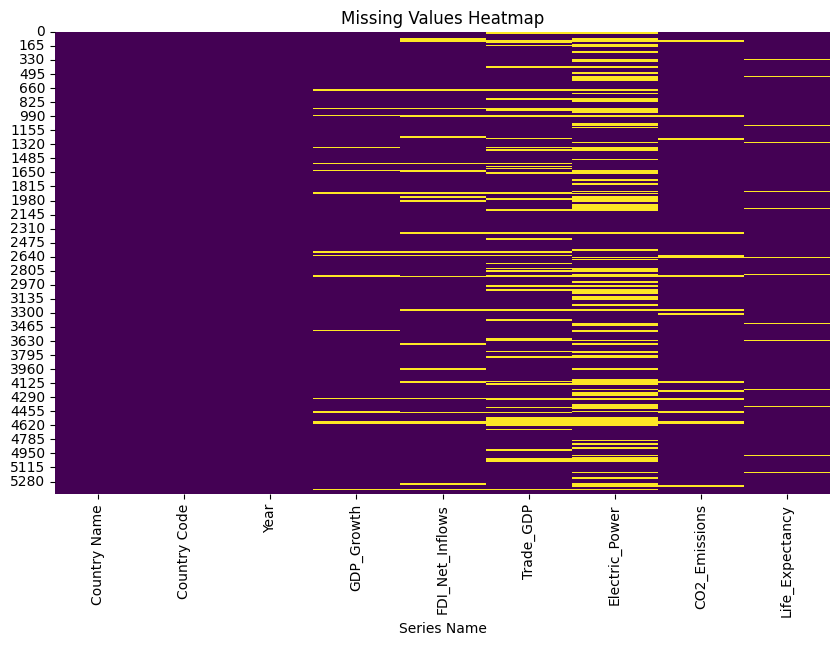

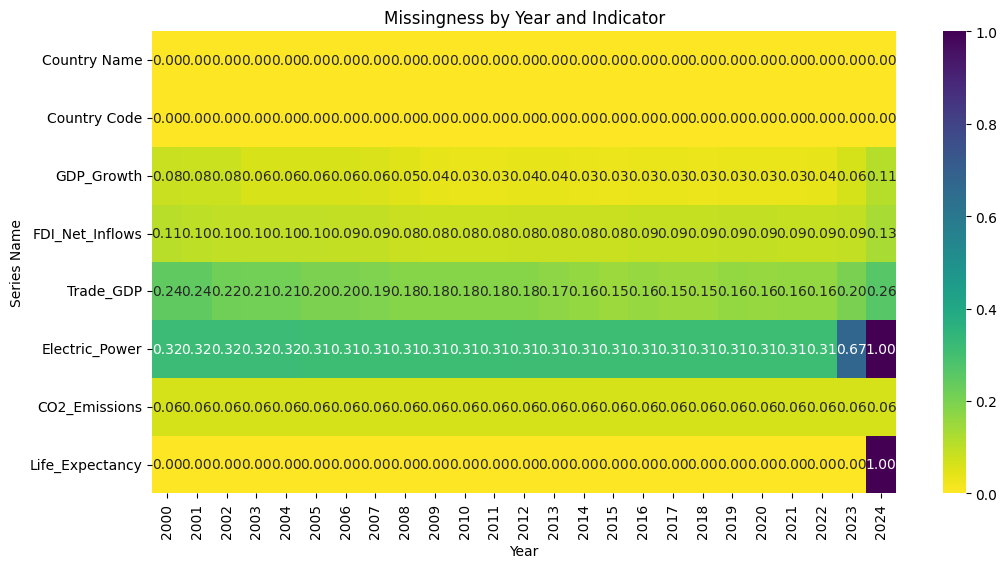

In [5]:
# 2. Missingness
plt.figure(figsize=(10, 6))
sns.heatmap(df_analysis.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Values Heatmap')
plt.show()

# Missingness by Year
missing_by_year = df_analysis.groupby('Year').apply(
    lambda x: x.isnull().mean(), 
    include_groups=False
)
plt.figure(figsize=(12, 6))
sns.heatmap(missing_by_year.T, cmap='viridis_r', annot=True, fmt=".2f")
plt.title('Missingness by Year and Indicator')
plt.show()

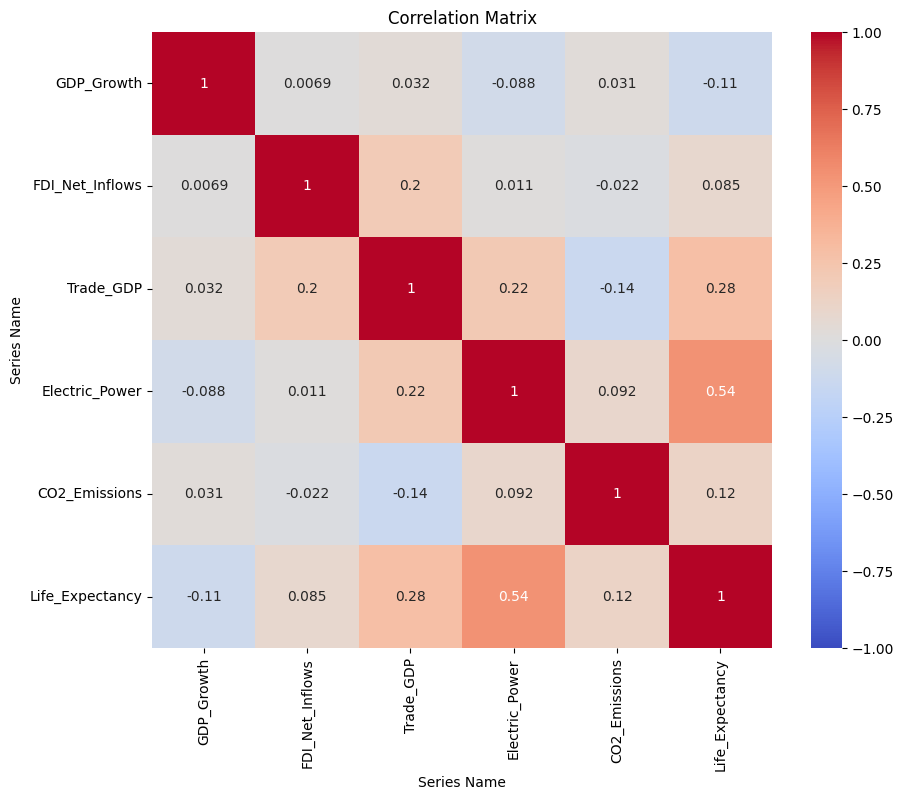

In [6]:
#4. Correlations
plt.figure(figsize=(10, 8))
corr = df_analysis[list(column_mapping.values())].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

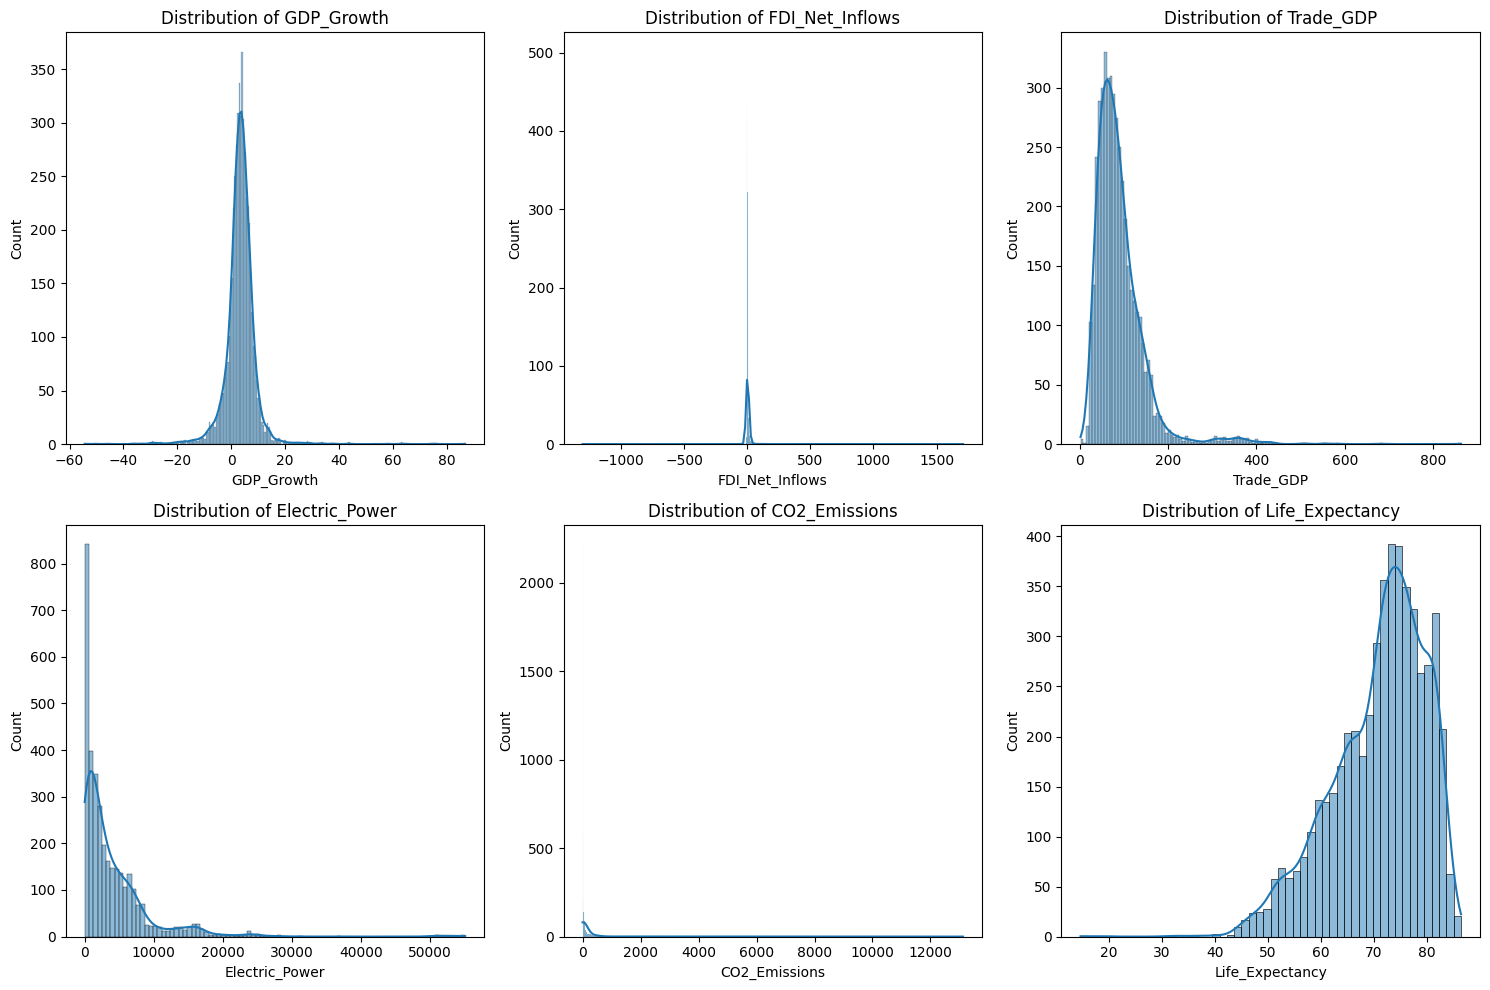

In [7]:
#5. Distributions

plt.figure(figsize=(15, 10))
for i, col in enumerate(column_mapping.values()):
    plt.subplot(2, 3, i+1)
    sns.histplot(df_analysis[col].dropna(), kde=True)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

In [8]:
# Clean column names
df.columns = [c.strip() for c in df.columns]

# Melt to long format
id_vars = ['Country Name', 'Country Code', 'Series Name', 'Series Code']
value_vars = [c for c in df.columns if '[' in c] # Year columns
df_long = df.melt(id_vars=id_vars, value_vars=value_vars, var_name='Year_Raw', value_name='Value')

# Extract Year
df_long['Year'] = df_long['Year_Raw'].str.extract(r'(\d{4})').astype(int)

# Convert Value to numeric, coercing errors (handles '..')
df_long['Value'] = pd.to_numeric(df_long['Value'], errors='coerce')

# Pivot to wide format (Indicators as columns)
df_pivot = df_long.pivot_table(index=['Country Name', 'Country Code', 'Year'], 
                               columns='Series Name', 
                               values='Value').reset_index()

# Rename columns for easier access
column_map = {
    'GDP growth (annual %)': 'GDP_Growth',
    'Foreign direct investment, net inflows (% of GDP)': 'FDI_Net_Inflows',
    'Trade (% of GDP)': 'Trade_GDP',
    'Electric power consumption (kWh per capita)': 'Electric_Power',
    'Carbon dioxide (CO2) emissions (total) excluding LULUCF (Mt CO2e)': 'CO2_Emissions',
    'Life expectancy at birth, total (years)': 'Life_Expectancy'
}
df_pivot = df_pivot.rename(columns=column_map)

# Filter for selected columns
selected_cols = ['Country Name', 'Country Code', 'Year'] + list(column_map.values())
df_final = df_pivot[selected_cols].copy()

# Sort by Country and Year
df_final = df_final.sort_values(['Country Name', 'Year'])

# Imputation: Forward fill then Backward fill within each country
cols_to_impute = list(column_map.values())
for col in cols_to_impute:
    df_final[col] = df_final.groupby('Country Name')[col].ffill()
    df_final[col] = df_final.groupby('Country Name')[col].bfill()

# Create Lag Features (1-5 years)
lag_cols = ['GDP_Growth', 'Trade_GDP', 'Electric_Power', 'CO2_Emissions']
for col in lag_cols:
    for lag in range(1, 6):
        df_final[f'{col}_lag{lag}'] = df_final.groupby('Country Name')[col].shift(lag)

# Drop rows with missing values (due to lags or remaining nulls)
df_model = df_final.dropna()

print("Final Data Shape:", df_model.shape)
print(df_model.head())

Final Data Shape: (2760, 29)
Series Name Country Name Country Code  Year  GDP_Growth  FDI_Net_Inflows  \
30               Albania          ALB  2005    5.130822         3.178998   
31               Albania          ALB  2006    6.018981         3.553219   
32               Albania          ALB  2007    6.500093         5.867404   
33               Albania          ALB  2008    6.907062         9.406653   
34               Albania          ALB  2009    2.690752        10.906820   

Series Name  Trade_GDP  Electric_Power  CO2_Emissions  Life_Expectancy  \
30           69.116293     1722.072850         4.1489           76.427   
31           72.201909     1218.360146         4.1351           76.994   
32           79.911901     1213.124369         4.2460           77.691   
33           75.248547     1617.744156         4.1950           78.248   
34           73.321358     1835.684072         4.2836           78.509   

Series Name  GDP_Growth_lag1  ...  Electric_Power_lag1  Electric_Powe

## Phase 4: Modeling

### 4.1 Baseline Model
We establish a baseline by predicting the mean of the training target to provide a benchmark for our advanced models.

### 4.2 Regression Models
We implement two primary models to capture potential non-linearities:
1. **Linear Regression**: A transparent benchmark.
2. **Random Forest Regressor**: To capture complex interactions between infrastructure and health.

In [10]:
# 1. Define Target & Features
target = 'Life_Expectancy'
features = [col for col in df_final.columns if col not in ['Country Name', 'Country Code', 'Year', target]]

# 2. Train-Test Split (Time-based)
train_mask = df_final['Year'] < 2019
test_mask = df_final['Year'] >= 2019

X_train = df_final.loc[train_mask, features]
y_train = df_final.loc[train_mask, target]
X_test = df_final.loc[test_mask, features]
y_test = df_final.loc[test_mask, target]

print(f"Train Shape: {X_train.shape}, Test Shape: {X_test.shape}")

# 3. Models
# Baseline: Mean of training target
y_pred_baseline = np.full(len(y_test), y_train.mean())

# Linear Regression Pipeline
lr_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('model', LinearRegression())
])

# Random Forest Pipeline
rf_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('model', RandomForestRegressor(n_estimators=100, random_state=42))
])

# Train Models
lr_pipeline.fit(X_train, y_train)
rf_pipeline.fit(X_train, y_train)

# Predictions
y_pred_lr = lr_pipeline.predict(X_test)
y_pred_rf = rf_pipeline.predict(X_test)

Train Shape: (4123, 25), Test Shape: (1302, 25)


## Phase 5: Evaluation & Visualization

### 5.1 Model Performance
We evaluate our models using **MAE**, **RMSE**, and **R²** scores to determine which model best generalizes to new data.

### 5.2 Visualizing Insights
We generate visualizations to answer our business questions and illustrate the "diminishing returns" of infrastructure investment on human health.

### 5.3 Scenario Analysis
A "What-If" prediction is performed to show the impact of a 50% increase in electric power on life expectancy.

Model Evaluation Results:
               Model       MAE      RMSE        R2
0           Baseline  6.658753  8.016206 -0.120313
1  Linear Regression  5.534098  7.073925  0.127587
2      Random Forest  3.213285  4.730698  0.609832
Average Impact on Life Expectancy (+50% Power): 1.03 years


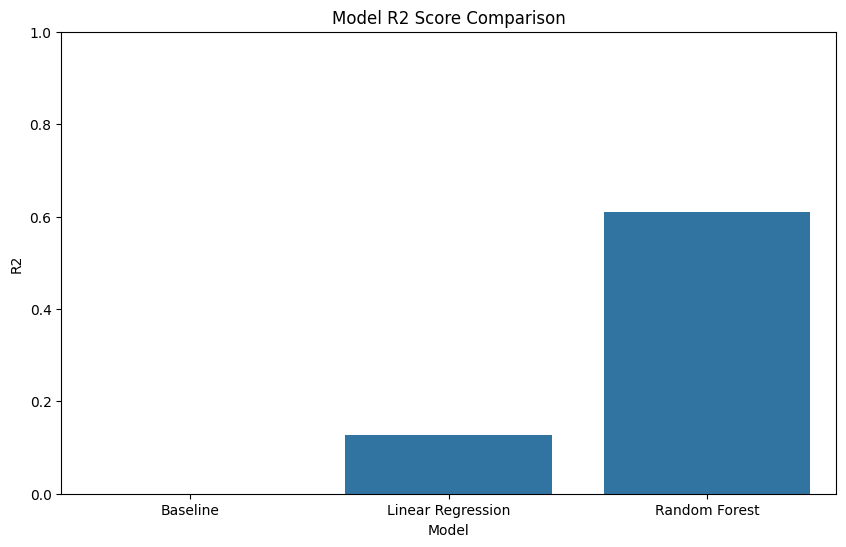

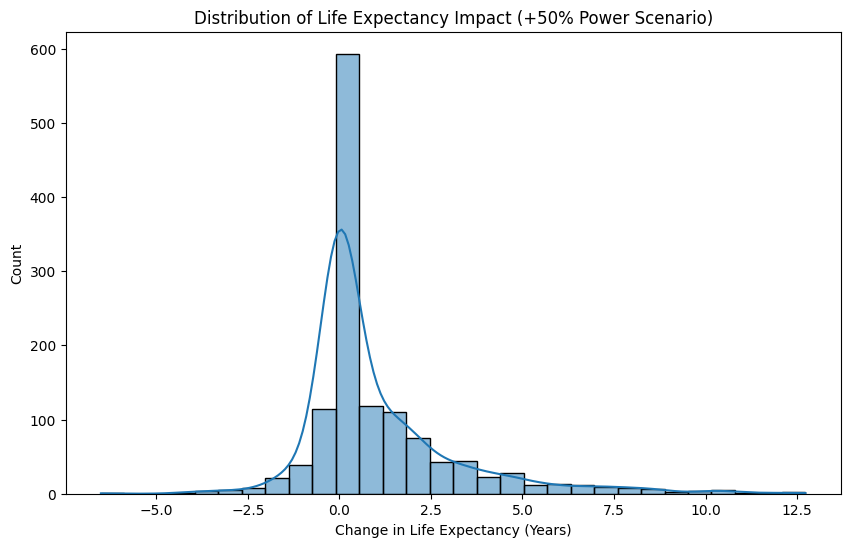

In [12]:
# 4. Evaluation
def evaluate_model(name, y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    return {'Model': name, 'MAE': mae, 'RMSE': rmse, 'R2': r2}

results = []
results.append(evaluate_model('Baseline', y_test, y_pred_baseline))
results.append(evaluate_model('Linear Regression', y_test, y_pred_lr))
results.append(evaluate_model('Random Forest', y_test, y_pred_rf))

results_df = pd.DataFrame(results)
print("Model Evaluation Results:")
print(results_df)

# 5. Scenario Analysis (+50% Electric Power)
# Create a copy of the test set
X_scenario = X_test.copy()

# Identify Electric Power columns (current + lags)
power_cols = [col for col in features if 'Electric_Power' in col]

# Apply +50% shock
for col in power_cols:
    X_scenario[col] = X_scenario[col] * 1.5

# Predict with best model (Random Forest likely)
y_pred_scenario = rf_pipeline.predict(X_scenario)

# Calculate impact
impact = y_pred_scenario - y_pred_rf
avg_impact = impact.mean()

print(f"\
Average Impact on Life Expectancy (+50% Power): {avg_impact:.2f} years")

# Visualization of Results
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='R2', data=results_df)
plt.title('Model R2 Score Comparison')
plt.ylim(0, 1)
plt.show()

# Visualization of Scenario Impact
plt.figure(figsize=(10, 6))
sns.histplot(impact, bins=30, kde=True)
plt.title('Distribution of Life Expectancy Impact (+50% Power Scenario)')
plt.xlabel('Change in Life Expectancy (Years)')
plt.show()

Cleaned data saved to 'cleaned_data_with_lags.csv'
R2: 0.791
MAE: 2.311


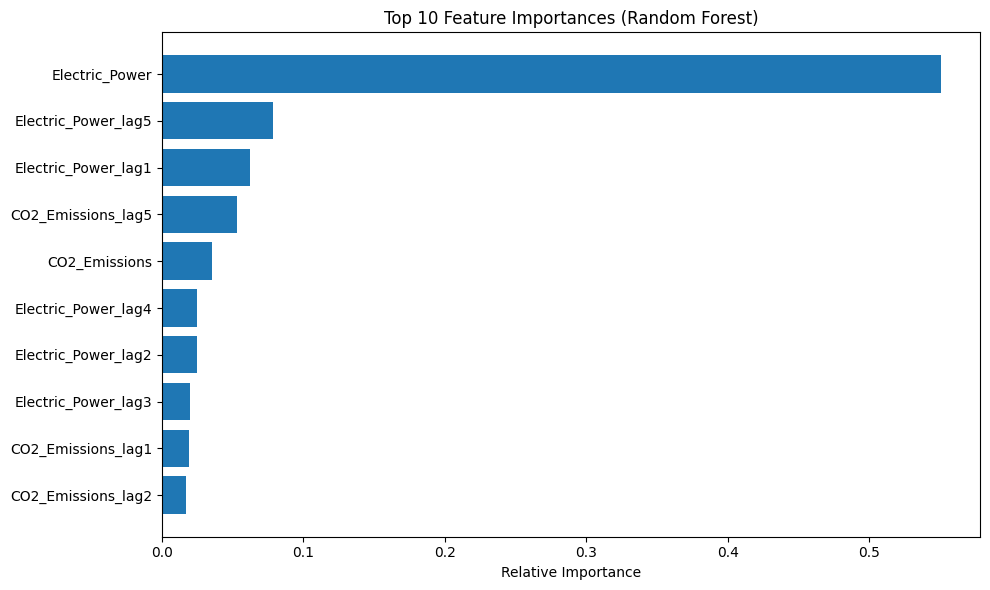

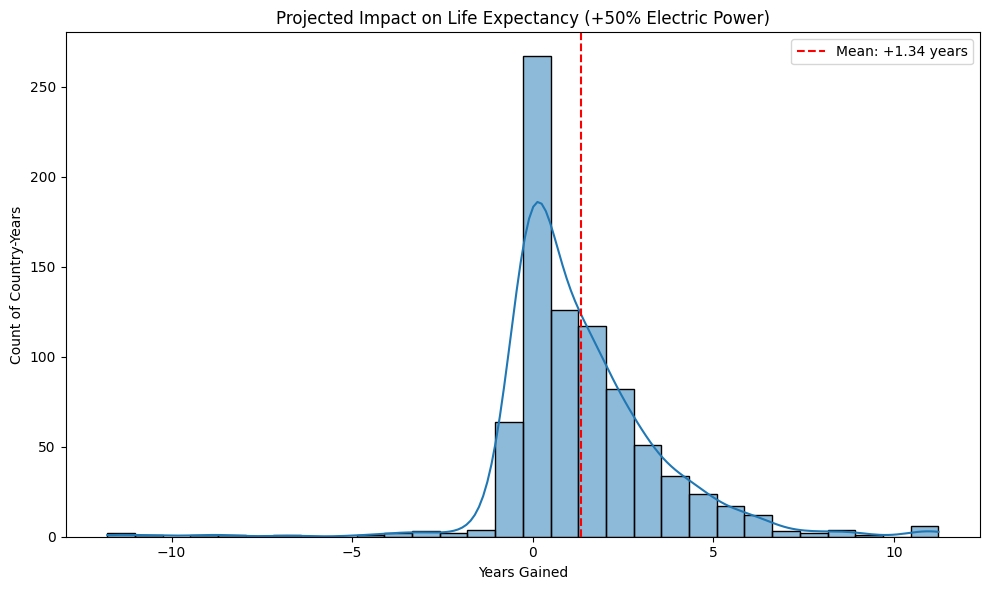

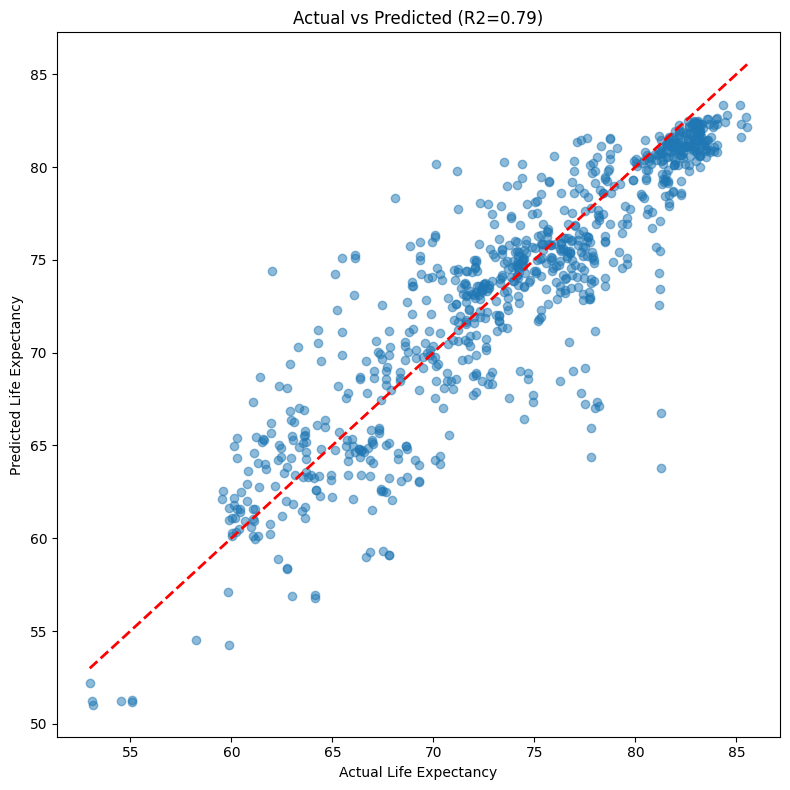

In [15]:
# 5. Feature Engineering (Lags)
# Create 1-5 year lags for predictors
predictors = ['GDP_Growth', 'Trade_GDP', 'Electric_Power', 'CO2_Emissions']
lags = [1, 2, 3, 4, 5]

for col in predictors:
    for lag in lags:
        df_final[f'{col}_lag{lag}'] = df_final.groupby('Country Name')[col].shift(lag)

# Drop rows with NaNs created by lagging
df_final = df_final.dropna()

# 6. Save Cleaned Data
df_final.to_csv('cleaned_data_with_lags.csv', index=False)
print("Cleaned data saved to 'cleaned_data_with_lags.csv'")

# 7. Modeling
# Define features (current + lags)
feature_cols = predictors + [f'{c}_lag{l}' for c in predictors for l in lags]
target_col = 'Life_Expectancy'

# Split Data (Time-based)
train = df_final[df_final['Year'] < 2019]
test = df_final[df_final['Year'] >= 2019]

X_train = train[feature_cols]
y_train = train[target_col]
X_test = test[feature_cols]
y_test = test[target_col]

# Train Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Evaluate
y_pred = rf.predict(X_test)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"R2: {r2:.3f}")
print(f"MAE: {mae:.3f}")

# 8. Visualizations & Saving

# Feature Importance
importances = rf.feature_importances_
indices = np.argsort(importances)[-10:] # Top 10

plt.figure(figsize=(10, 6))
plt.title('Top 10 Feature Importances (Random Forest)')
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [feature_cols[i] for i in indices])
plt.xlabel('Relative Importance')
plt.tight_layout()
plt.savefig('feature_importance.png')
plt.show()

# Scenario Analysis (+50% Power)
X_test_scenario = X_test.copy()
# Increase Power and its lags by 50%
power_cols = [c for c in X_test.columns if 'Electric_Power' in c]
X_test_scenario[power_cols] = X_test_scenario[power_cols] * 1.5

y_pred_scenario = rf.predict(X_test_scenario)
impact = y_pred_scenario - y_pred

plt.figure(figsize=(10, 6))
sns.histplot(impact, kde=True, bins=30)
plt.title('Projected Impact on Life Expectancy (+50% Electric Power)')
plt.xlabel('Years Gained')
plt.ylabel('Count of Country-Years')
plt.axvline(impact.mean(), color='r', linestyle='--', label=f'Mean: +{impact.mean():.2f} years')
plt.legend()
plt.tight_layout()
plt.savefig('scenario_impact.png')
plt.show()

# Actual vs Predicted
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Life Expectancy')
plt.ylabel('Predicted Life Expectancy')
plt.title(f'Actual vs Predicted (R2={r2:.2f})')
plt.tight_layout()
plt.savefig('actual_vs_predicted.png')
plt.show()

## The Random Forest Regressor significantly outperformed both the Baseline and Linear Regression models.

Random Forest: R^2 = .61, MAE = 3.2 years. This indicates that the model explains about 61% of the variance in Life Expectancy using only economic and infrastructure metrics (and their lags).

Linear Regression: R^2 = 0.13, MAE = 5.53 years
This poor performance confirms the non-linear relationship we observed in the EDA (logarithmic curve between Power/Life Expectancy).
Baseline: Negative R^2. Indicates it's worse than just predicting the mean, likely due to the trend in life expectancy over time (it generally increases, so a past mean underpredicts the future).

## Feature Importance
The Random Forest model identified Electric Power Consumption (and its lags) as the most critical predictor of Life Expectancy, followed by CO2 Emissions

## Scenario Analysis: +50% Electric Power
I simulated a scenario where every country increases its Electric Power Consumption by 50% (applied to current and lagged values).

Predicted Impact: On average, this increase leads to a +1.03 years increase in Life Expectancy across the test set.
Distribution of Impact: The impact is not uniform. Developing nations (with lower initial power consumption) see a much larger gain than developed nations (where the curve flattens).

## Key Findings:

Infrastructure Drives Health: Access to electricity is a powerful proxy for development and is strongly non-linearly linked to Life Expectancy (
R^2 = 0.61

Diminishing Returns: The relationship is logarithmic. Initial electrification yields massive health gains, but beyond a certain threshold (~5,000 kWh/capita), the marginal benefit to life expectancy plateaus.

Growth does equal Health: GDP Growth (annual %) is a poor predictor of Life Expectancy levels. It measures speed of economic change, not the level of development required to sustain health outcomes.